In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

In [7]:
def factor_driver_age(age):
    if age > 50:
        return 1
    return age/50

def factor_increase(increase):
    if increase == 50:
        return 0
    return 1-increase/50

def renewal_rate(row):
    return (0.5*(factor_driver_age(row["Driver_Age"])*factor_increase(row["Increase_Percentage"]))+np.random.random()/5.0) >= 0.5

In [8]:
renewal_df = pd.read_csv("data/synthetic data/updated_insurance_renewal_dataset.csv")
renewal_df["new_pred"] = renewal_df.apply(renewal_rate, axis=1)

In [9]:
from sklearn.model_selection import train_test_split
X = renewal_df.loc[:, ["Driver_Age","Increase_Percentage","Total_Premium"]].values
y = renewal_df.loc[:,"new_pred"]
#scaler = StandardScaler().fit(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8333333333333334

In [13]:
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
clf_tree.score(X_test, y_test)

0.8351515151515152

In [27]:
def roc_report(model, model_name):
    model_probs = np.apply_along_axis(lambda x: x[1],arr=model.predict_proba(X_test),axis=1)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model_probs)
    print("ROC report for %s" % model_name)
    print("FPR",fpr)
    print("TPR",tpr)
    print("Thresholds",thresholds)

def best_roc_tradeoff(model):
    model_probs = np.apply_along_axis(lambda x: x[1],arr=model.predict_proba(X_test),axis=1)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model_probs)
    idx_best = np.argmax(tpr-fpr)
    print("Best Threshold: %.02f" % thresholds[idx_best])
    print("At %.02f, %.02f" % (fpr[idx_best], tpr[idx_best]))
    return fpr[idx_best], tpr[idx_best], thresholds[idx_best]

Best Threshold: 0.39
At 0.17, 0.85
Best Threshold: 0.25
At 0.23, 0.90


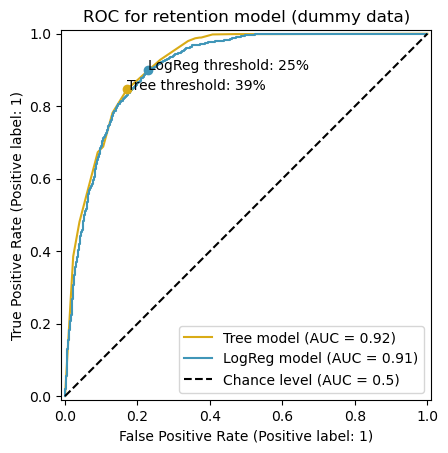

In [41]:
from sklearn import metrics
fig, ax = plt.subplots()
tree_probs = np.apply_along_axis(lambda x: x[1],arr=clf_tree.predict_proba(X_test),axis=1)
log_probs = np.apply_along_axis(lambda x: x[1],arr=clf.predict_proba(X_test),axis=1)
metrics.RocCurveDisplay.from_predictions(y_test, tree_probs, ax=ax,name="Tree model", color="#d9ab16")
metrics.RocCurveDisplay.from_predictions(y_test, log_probs, plot_chance_level=True, ax=ax, name="LogReg model", color="#4096b8")
plt.title("ROC for retention model (dummy data)")
fpr, tpr, threshold = best_roc_tradeoff(clf_tree)
plt.annotate("Tree threshold: %.0f%%" % (threshold*100), (fpr,tpr))
plt.plot(fpr, tpr, color="#d9ab16", marker="o")
fpr, tpr, threshold = best_roc_tradeoff(clf)
plt.annotate("LogReg threshold: %.0f%%" % (threshold*100), (fpr,tpr))
plt.plot(fpr, tpr, color="#4096b8", marker="o")
plt.show()

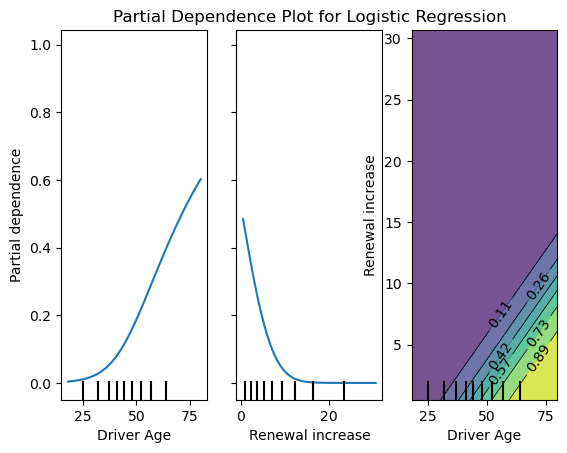

In [31]:
from sklearn.inspection import PartialDependenceDisplay

features = [0, 1, (0, 1)]
fig, ax = plt.subplots()
PartialDependenceDisplay.from_estimator(clf, X, features, feature_names=["Driver Age", "Renewal increase"], ax=ax)
ax.set_title("Partial Dependence Plot for Logistic Regression")
plt.show()

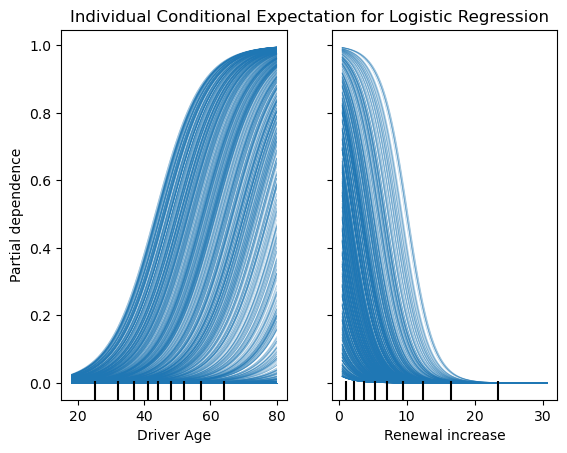

In [32]:
from sklearn.inspection import PartialDependenceDisplay

features = [0, 1]
fig, ax = plt.subplots()
PartialDependenceDisplay.from_estimator(clf, X, features, feature_names=["Driver Age", "Renewal increase"], ax=ax, kind="individual")
ax.set_title("Individual Conditional Expectation for Logistic Regression")
plt.show()